# CNC SMS Prediction using LSTM layers

Иммется временной ряд отправленных СМС оповещений за 4 месяца с периодичнотью в 10 мин.
Требуебся выдать прогноз на n временных интервалов вперед и визуализировать результаты используя рекуррентные нейроннный сети с долгосрочно-краткосрочной памятью

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler 

from keras.models import Sequential  
from keras.layers import Dense, LSTM, Dropout 
from keras.callbacks import ReduceLROnPlateau
from keras.layers.advanced_activations import *

pd.options.display.float_format = '{:.3f}'.format

WINDOW = 24
NUM_EPOCHS = 10
BATCH_SIZE = 256

Загрузим входные данные, сделаем их предобработку, выведем некоторые статистические показатели, и визуализируем их

Populating the interactive namespace from numpy and matplotlib


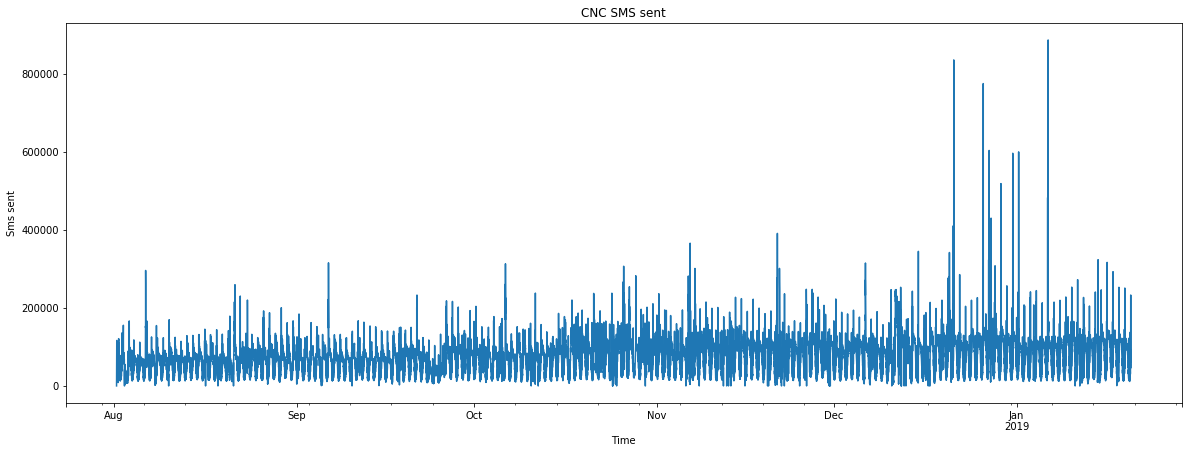

count    24768.000
mean     68637.886
std      42793.965
min          1.000
25%      30642.750
50%      68145.500
75%      96240.000
max     886752.000
Name: Value, dtype: float64


In [142]:
%pylab inline
df = pd.read_csv('10min.csv', sep=';', index_col=['Time'], parse_dates=['Time'], dayfirst=True)
df = df.drop(df['Value'].tail(1).index)
n = int(df['Value'].size/2)
df = df[n:]
df['Value'] = df['Value'].apply(lambda text: ''.join(j for j in text if ord(j) < 128))
df['Value'] = df['Value'].apply(lambda val: float(val))
df['Value'] = df['Value'].apply(lambda val: 1 if val <= 0 else val)
df['Value'] = df['Value'].asfreq('10min', method='pad')
data = df['Value']
plt.figure(figsize(20,7))
data.plot()
plt.title("CNC SMS sent")
plt.ylabel('Sms sent')
plt.show()  

print(data.describe())

Нормализуем входные данные по формуле: 
    $${X_i}_{normalized}=\frac{X_i−X_{min}}{X_{max}−X_{min}} $$

И разделим наши данные на множества X (признаков) и Y (меток)  
Для подготовки данных будем пользоваться принципом скользящего окна.  
Таким образом, на вход сети подается массив длиной n из окон заданного размера m из значений за m промежутков времени, а на выходе мы хотим знать значение в m+1 промежуток времени  
Для работы LSTM слои нам нужно преобразовать входные данные - признаки в 3D тензоры. Просто добавим одно измерение функцией из numpy

In [ ]:
data = np.expand_dims(data, axis=1)

scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(data)

In [143]:
features = []  
labels = []

for i in range(WINDOW, len(data):  
    features.append(data_scaled[i-WINDOW:i])
    labels.append(data_scaled[i])

features, labels = np.array(features), np.array(labels) 
features = np.reshape(features, (features.shape[0], features.shape[1], 1)) 

Разделим множества признаокво и и меток на обучающую и тестовую выборки в соотношении 8/2

In [144]:
validation_barrier = int(len(labels)*0.8)

Y_train = labels[:validation_barrier]
X_train = features[:validation_barrier]
Y_test = labels[validation_barrier:]
X_test = features[validation_barrier:]

Тут можно долго играться с функциями активации, количеством слоев/нейронов, дропаутом и рекуррентным дропаутом 

In [145]:
act_func = 'tanh'

model = Sequential()  
model.add(LSTM(units=50, activation=act_func, return_sequences=True, input_shape=(features.shape[1], 1)))  
model.add(Dropout(0.2))  

model.add(LSTM(units=50, activation=act_func, return_sequences=True))  
model.add(Dropout(0.2))

#model.add(LSTM(units=50, return_sequences=True))  
#model.add(Dropout(0.2))

model.add(LSTM(units=50, activation=act_func))  
model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mean_squared_error')

#reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1) recurrent_dropout=0.2

In [146]:
history = model.fit(X_train, Y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test, Y_test),
                    shuffle=False)

#predictions = scaler.inverse_transform(predictions) 

Train on 19795 samples, validate on 4949 samples
Epoch 1/10
19795/19795 [==============================] - 21s 1ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 2/10
19795/19795 [==============================] - 18s 924us/step - loss: 7.3890e-04 - val_loss: 0.0018
Epoch 3/10
19795/19795 [==============================] - 20s 993us/step - loss: 7.1045e-04 - val_loss: 0.0018
Epoch 4/10
19795/19795 [==============================] - 18s 932us/step - loss: 6.8880e-04 - val_loss: 0.0018
Epoch 5/10
19795/19795 [==============================] - 22s 1ms/step - loss: 6.7016e-04 - val_loss: 0.0018
Epoch 6/10
19795/19795 [==============================] - 19s 973us/step - loss: 6.5695e-04 - val_loss: 0.0018
Epoch 7/10
19795/19795 [==============================] - 18s 929us/step - loss: 6.4214e-04 - val_loss: 0.0018
Epoch 8/10
19795/19795 [==============================] - 17s 867us/step - loss: 6.2388e-04 - val_loss: 0.0018
Epoch 9/10
19795/19795 [==============================] - 17s 875us/ste

Выведем статистику обучения

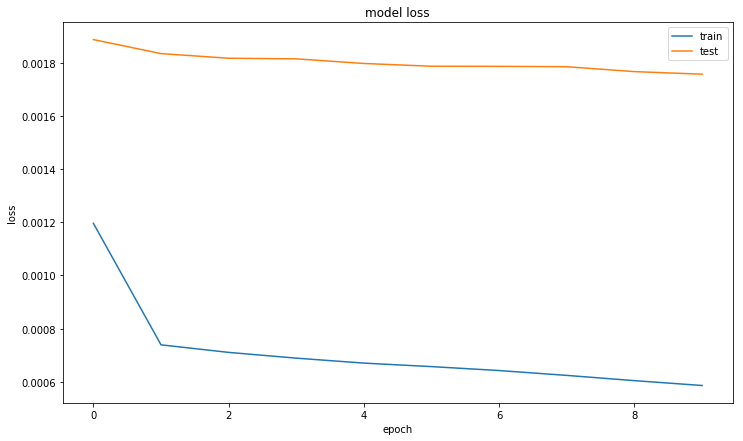

In [147]:
plt.figure(figsize=(12,7))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [148]:
pred = model.predict(X_test) 

beg = df['Value'].index[-len(Y_test)]
end = df['Value'].index[-1]

dr = pd.date_range(start=beg, end=end, freq ='10min')

actual = pd.Series(np.squeeze(Y_test,axis=1), index=dr)
predicted = pd.Series(np.squeeze(pred,axis=1), index=dr)

Визуализируем результаты модели на тестовой выборке

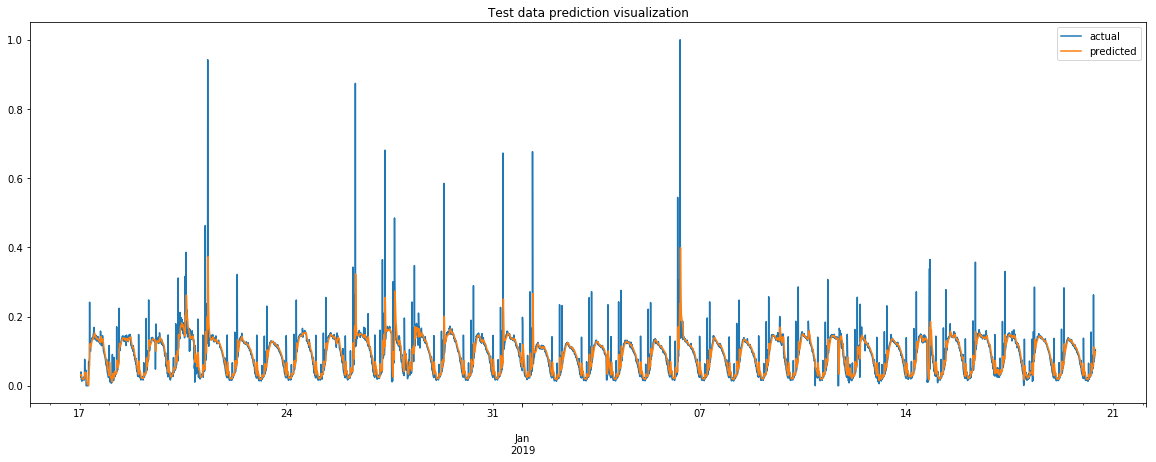

In [149]:
actual.plot(label='actual')
predicted.plot(label='predicted')
plt.legend(loc='best')
plt.title('Test data prediction visualization')
plt.show()

А теперь визуализируем меньший интревал - 1 день:

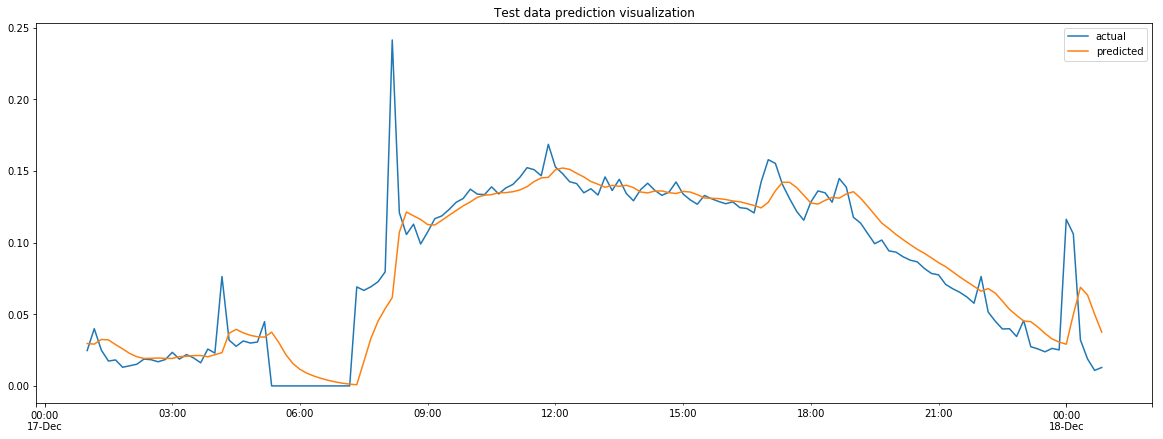

In [150]:
FROM = 0
TO = 6*24

actual[FROM:TO].plot(label='actual')
predicted[FROM:TO].plot(label='predicted')
plt.legend(loc='best')
plt.title('Test data prediction visualization')
plt.show()